In [1]:
import cv2
# import Libraries
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, GlobalAveragePooling2D, multiply, Lambda, Dropout,BatchNormalization, Attention, Input
from keras.callbacks import EarlyStopping
import keras.backend as K

In [2]:
# Define paths
train_dir = 'D:/deep_space/MV/Dataset_split_3/Train'
test_dir = 'D:/deep_space/MV/Dataset_split_3/Test'

In [3]:
# Load and preprocess the training data
input_shape = (128, 128, 3)
batch_size=16

# Load and preprocess the test data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=[0.64, 1.0],
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.177)

'''
                                   rotation_range=20,  # 随机旋转图像（0-180度之间）
                                   width_shift_range=0.2,  # 随机水平平移图像
                                   height_shift_range=0.2,  # 随机垂直平移图像
                                   shear_range=0.2,  # 随机错切变换
                                   zoom_range=0.2,  # 随机缩放图像
                                   horizontal_flip=True,  # 随机水平翻转图像
                                   fill_mode='nearest',  # 用于填充新创建像素的方法
                                   brightness_range=[0.5, 1.5],

'''

                                   
val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.177)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)


Found 274 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 60 images belonging to 4 classes.


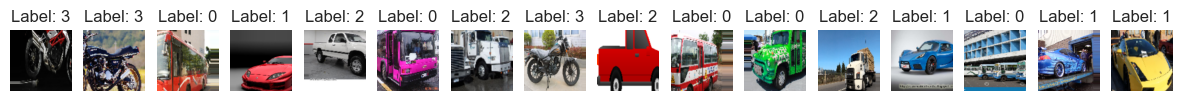

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def first_baseModel(input_shape=input_shape):  # Adjust input shape as per your requirements
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu', padding="same")(input_tensor)
    x = MaxPooling2D()(x)
    
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x)
    return model


In [7]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.dense1 = Dense(units=input_shape[-1] // self.reduction_ratio, activation='relu')
        self.dense2 = Dense(units=input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        # 全局平均池化
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = Reshape((1, 1, avg_pool.shape[1]))(avg_pool)

        # 通过两层全连接层
        channel_att = self.dense1(avg_pool)
        channel_att = self.dense2(channel_att)

        # 调整通道权重
        return Multiply()([inputs, channel_att])

In [8]:
def second_baseModel(input_shape=input_shape):  # Adjust input shape as per your requirements
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same")(input_tensor)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    
   
    x = Flatten()(x)
    x = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x)
    return model


In [9]:
from keras.layers import Multiply


class Attention2(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention2, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')
        super(Attention2, self).build(input_shape)

    def call(self, x):
        attention_mask = self.conv(x)
        return Multiply()([x, attention_mask])

In [10]:
model = first_baseModel()

In [11]:
# model = base_model(input_shape)

In [12]:
# computing attention weights. Each element in the input tensor x will be assigned a weight by this dense layer
# attention = Dense(1, activation='tanh')(x)

In [13]:
# Reshape attention to have dimensions (-1, 1, 1)
# attention = Reshape((-1, 1, 1))(attention)

In [14]:
# Apply the attention weights element-wise to the original feature representation (x) 
# attention = multiply([x, attention])

In [15]:
# The attention weights are summed along the channel axis (-2) to produces a single attention value 
# attention = Lambda(lambda x: K.sum(x, axis=-2))(attention)

In [16]:
# The attention values are expanded along a new axis (-1)
# attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)

In [17]:
# computes the average of all the values along each channel
# attention = GlobalAveragePooling2D()(attention)

In [18]:
# merged = Dense(4, activation='softmax')(attention)

In [19]:
# Create the new model
# model = Model(inputs=base_model.input, outputs=merged)
# model = Model(inputs=base_model.input, outputs=output)

In [20]:
# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856 

In [21]:
# Compile the model
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
              )

In [22]:
# Train the model
history = model.fit(train_generator, validation_data=(val_generator), epochs=40)

Epoch 1/40
18/18 [==============================] - 23s 1s/step - loss: 5.8198 - accuracy: 0.2226 - val_loss: 2.6035 - val_accuracy: 0.2456
Epoch 2/40
18/18 [==============================] - 18s 1s/step - loss: 2.1566 - accuracy: 0.2372 - val_loss: 1.7795 - val_accuracy: 0.3684
Epoch 3/40
18/18 [==============================] - 18s 987ms/step - loss: 1.6103 - accuracy: 0.2628 - val_loss: 1.4967 - val_accuracy: 0.2632
Epoch 4/40
18/18 [==============================] - 18s 990ms/step - loss: 1.4655 - accuracy: 0.2993 - val_loss: 1.3860 - val_accuracy: 0.2632
Epoch 5/40
18/18 [==============================] - 18s 993ms/step - loss: 1.4313 - accuracy: 0.2482 - val_loss: 1.4388 - val_accuracy: 0.2632
Epoch 6/40
18/18 [==============================] - 18s 1s/step - loss: 1.4267 - accuracy: 0.2044 - val_loss: 1.4080 - val_accuracy: 0.2456
Epoch 7/40
18/18 [==============================] - 18s 1s/step - loss: 1.4004 - accuracy: 0.2299 - val_loss: 1.3930 - val_accuracy: 0.2456
Epoch 8/40


In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 14s 769ms/step - loss: 1.1398 - accuracy: 0.4964
Test Accuracy: 0.49635037779808044
Test loss: 1.1398365497589111


In [24]:
test_loss, test_accuracy = model.evaluate(val_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

4/4 [==============================] - 3s 744ms/step - loss: 1.5705 - accuracy: 0.4561
Test Accuracy: 0.45614033937454224
Test loss: 1.570511817932129


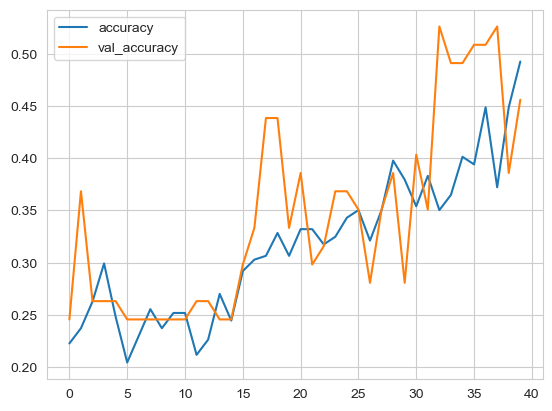

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

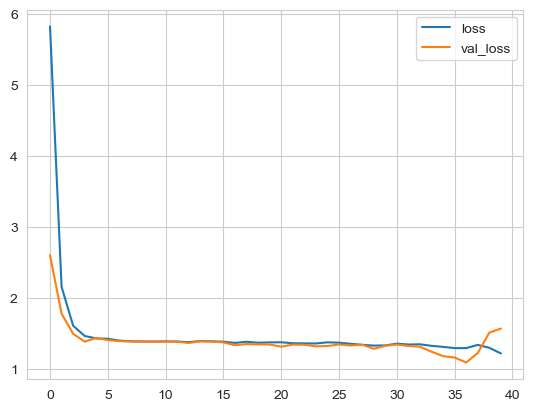

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()